In [2]:
import nibabel as nib
import numpy as np
import nilearn
from nilearn import plotting

In [3]:
import pandas as pd

# Path to the .stats file
stats_file_path = '/projectnb/vkolagrp/spuduch/mni/fastsurfer/stats/aseg+DKT.stats'

# Load the .stats file into a DataFrame
stats_df = pd.read_csv(stats_file_path, sep=r'\s+', comment='#', header=None)
stats_df.columns = ['Index', 'LabelID', 'Unknown1', 'Unknown2', 'RegionName', 'Unknown4', 'Unknown5', 'Unknown6', 'Unknown7', 'Unknown3']
stats_df = stats_df.drop(columns=['Index', 'Unknown1', 'Unknown2', 'Unknown3', 'Unknown4', 'Unknown5', 'Unknown6', 'Unknown7'])
# turn stats_df into a dictionary for RegionName: LabelID
stats_dict = dict(zip(stats_df['RegionName'], stats_df['LabelID']))


In [4]:
field_mapping = {
    # 'Are there prior hemorrhages present?': None, # not using swi anymore
    # 'Are there prior infarcts present?': None, # ^^
    'Atrophy/volume loss in the frontal lobe': [
        'ctx-lh-superiorfrontal', 'ctx-rh-superiorfrontal',
        'ctx-lh-rostralmiddlefrontal', 'ctx-rh-rostralmiddlefrontal',
        'ctx-lh-caudalmiddlefrontal', 'ctx-rh-caudalmiddlefrontal',
        'ctx-lh-parsopercularis', 'ctx-rh-parsopercularis',
        'ctx-lh-parsorbitalis', 'ctx-rh-parsorbitalis',
        'ctx-lh-parstriangularis', 'ctx-rh-parstriangularis',
        'ctx-lh-precentral', 'ctx-rh-precentral',
        'ctx-lh-medialorbitofrontal', 'ctx-rh-medialorbitofrontal',
        'ctx-lh-lateralorbitofrontal', 'ctx-rh-lateralorbitofrontal',
        'ctx-lh-paracentral', 'ctx-rh-paracentral',
        'ctx-lh-caudalanteriorcingulate','ctx-rh-caudalanteriorcingulate'
    ],
    'Frontal lobe (general)': [
        'ctx-lh-superiorfrontal', 'ctx-rh-superiorfrontal',
        'ctx-lh-rostralmiddlefrontal', 'ctx-rh-rostralmiddlefrontal',
        'ctx-lh-caudalmiddlefrontal', 'ctx-rh-caudalmiddlefrontal',
        'ctx-lh-parsopercularis', 'ctx-rh-parsopercularis',
        'ctx-lh-parsorbitalis', 'ctx-rh-parsorbitalis',
        'ctx-lh-parstriangularis', 'ctx-rh-parstriangularis',
        'ctx-lh-precentral', 'ctx-rh-precentral',
        'ctx-lh-medialorbitofrontal', 'ctx-rh-medialorbitofrontal',
        'ctx-lh-lateralorbitofrontal', 'ctx-rh-lateralorbitofrontal',
        'ctx-lh-paracentral', 'ctx-rh-paracentral',
        'ctx-lh-caudalanteriorcingulate','ctx-rh-caudalanteriorcingulate'
    ],
    'Left anterior insula': ['ctx-lh-insula'], # even though we asked about anterior insula, we are using the whole insula as a ref
    'Right anterior insula': ['ctx-rh-insula'], # even though we asked about anterior insula, we are using the whole insula as a ref
    'Left anterior cingulate gyrus': ['ctx-lh-rostralanteriorcingulate', 'ctx-lh-caudalanteriorcingulate'],
    'Right Anterior cingulate gyrus': ['ctx-rh-rostralanteriorcingulate', 'ctx-rh-caudalanteriorcingulate'],
    'Left precentral gyrus': ['ctx-lh-precentral'],
    'Right precentral gyrus': ['ctx-rh-precentral'],
    'Left caudate nucleus': ['Left-Caudate'],
    'Right caudate nucleus': ['Right-Caudate'],
    'Is there mesial temporal lobe atrophy?': ['Left-Hippocampus', 'Left-Amygdala', 'ctx-lh-parahippocampal', 'ctx-lh-entorhinal',
                                            'Right-Hippocampus', 'Right-Amygdala', 'ctx-rh-parahippocampal', 'ctx-rh-entorhinal'],
    'Mesial Temporal lobe atrophy (rating) ': ['Left-Hippocampus', 'Left-Amygdala', 'ctx-lh-parahippocampal', 'ctx-lh-entorhinal',
                                            'Right-Hippocampus', 'Right-Amygdala', 'ctx-rh-parahippocampal', 'ctx-rh-entorhinal'],
    'Left mesial temporal lobe': ['Left-Hippocampus', 'Left-Amygdala', 'ctx-lh-parahippocampal', 'ctx-lh-entorhinal'],
    'Right mesial temporal lobe': ['Right-Hippocampus', 'Right-Amygdala', 'ctx-rh-parahippocampal', 'ctx-rh-entorhinal'],
    'Left hippocampus': ['Left-Hippocampus'],
    'Right hippocampus': ['Right-Hippocampus'],
    'Left amygdala': ['Left-Amygdala'],
    'Right amygdala': ['Right-Amygdala'],
    'Atrophy of left parahippocampus?': ['ctx-lh-parahippocampal'],
    'Atrophy of right parahippocampus?': ['ctx-rh-parahippocampal'],
    'Is there non-mesial temporal lobe atrophy?': ['ctx-lh-transversetemporal', 'ctx-lh-middletemporal', 'ctx-lh-superiortemporal', 'ctx-lh-inferiortemporal',
                                                  'ctx-rh-transversetemporal', 'ctx-rh-middletemporal', 'ctx-rh-superiortemporal', 'ctx-rh-inferiortemporal'],
    'Non-Mesial Temporal Lobe Atrophy (rating)': ['ctx-lh-transversetemporal', 'ctx-lh-middletemporal', 'ctx-lh-superiortemporal', 'ctx-lh-inferiortemporal',
                                                  'ctx-rh-transversetemporal', 'ctx-rh-middletemporal', 'ctx-rh-superiortemporal', 'ctx-rh-inferiortemporal'],
    'Left lateral temporal lobe': ['ctx-rh-inferiortemporal', 'ctx-lh-middletemporal', 'ctx-lh-transversetemporal', 'ctx-lh-superiortemporal'],
    'Right lateral temporal lobe': ['ctx-rh-inferiortemporal', 'ctx-rh-middletemporal', 'ctx-rh-transversetemporal', 'ctx-rh-superiortemporal'],
    # 'Anterior temporal lobe': I don't think we can map this to the DKT atlas bc the gyri are not well defined
    # 'Posterior temporal lobe': ^ same
    'Left fusiform gyrus': ['ctx-lh-fusiform'],
    'Right fusiform gyrus': ['ctx-rh-fusiform'],
    'Left middle and inferior temporal gyrus': ['ctx-lh-middletemporal', 'ctx-lh-inferiortemporal'],
    'Right middle and  inferior temporal gyrus': ['ctx-rh-middletemporal', 'ctx-rh-inferiortemporal'],
    'Is there parietal lobe atrophy?': ["ctx-lh-inferiorparietal", "ctx-lh-precuneus", "ctx-lh-superiorparietal", "ctx-lh-supramarginal", 'ctx-lh-postcentral',
                                        "ctx-rh-inferiorparietal", "ctx-rh-precuneus", "ctx-rh-superiorparietal", "ctx-rh-supramarginal", 'ctx-rh-postcentral'],
    'left parietal lobe atrophy (general)': ["ctx-lh-inferiorparietal", "ctx-lh-precuneus", "ctx-lh-superiorparietal", "ctx-lh-supramarginal"],
    'right parietal lobe atrophy (general)': ["ctx-rh-inferiorparietal", "ctx-rh-precuneus", "ctx-rh-superiorparietal", "ctx-rh-supramarginal"],
    'Is there occipital lobe atrophy?': [
        'ctx-lh-lingual','ctx-rh-lingual',
        'ctx-lh-pericalcarine', 'ctx-rh-pericalcarine',
        'ctx-lh-cuneus', 'ctx-rh-cuneus',
        'ctx-lh-lateraloccipital', 'ctx-rh-lateraloccipital'],
    'Atrophy in the occipital lobe': [
        'ctx-lh-lingual','ctx-rh-lingual',
        'ctx-lh-pericalcarine', 'ctx-rh-pericalcarine',
        'ctx-lh-cuneus', 'ctx-rh-cuneus',
        'ctx-lh-lateraloccipital', 'ctx-rh-lateraloccipital'],
    'Atrophy in the brain stem': ['Brain-Stem'],
    # 'Atrophy of the substantia nigra': # def not possible to map
    'Atrophy in the cerebellum': ['Left-Cerebellum-Cortex', 'Right-Cerebellum-Cortex', 'Left-Cerebellum-White-Matter','Right-Cerebellum-White-Matter'],
}

# 'Left temporal lobe' and  'Right temporal lobe' are just nonmesial and mesial temporal lobes combined
field_mapping['Left temporal lobe'] = field_mapping['Left mesial temporal lobe'] + ['ctx-lh-transversetemporal', 'ctx-lh-middletemporal', 'ctx-lh-superiortemporal', 'ctx-lh-inferiortemporal', 'ctx-lh-fusiform']
field_mapping['Right temporal lobe'] = field_mapping['Right mesial temporal lobe'] + ['ctx-rh-transversetemporal', 'ctx-rh-middletemporal', 'ctx-rh-superiortemporal', 'ctx-rh-inferiortemporal', 'ctx-rh-fusiform']

limbic_system_list = [
    "Left-Amygdala",
    "Right-Amygdala",
    "Left-Hippocampus",
    "Right-Hippocampus",
    "ctx-lh-parahippocampal",
    "ctx-rh-parahippocampal",
    "ctx-lh-entorhinal",
    "ctx-rh-entorhinal",
    "ctx-lh-isthmuscingulate","ctx-rh-isthmuscingulate",
    "ctx-lh-posteriorcingulate","ctx-rh-posteriorcingulate",
    'ctx-lh-caudalanteriorcingulate','ctx-rh-caudalanteriorcingulate',
    'ctx-lh-rostralanteriorcingulate', 'ctx-rh-rostralanteriorcingulate',
    'Left-Thalamus', 'Right-Thalamus',
    'CC_Anterior', 'CC_Central', 'CC_Mid_Anterior','CC_Mid_Posterior','CC_Posterior'
]
limbic_system_set = set(limbic_system_list)
field_mapping_set = set()
for key, value in field_mapping.items():
    field_mapping_set.update(value)

all_regions_set = set()
for key, _ in stats_dict.items():
    all_regions_set.add(key)

print(all_regions_set - field_mapping_set - limbic_system_set)

{'4th-Ventricle', 'Left-Accumbens-area', 'Left-Putamen', 'Left-VentralDC', 'Right-Cerebral-White-Matter', 'Left-choroid-plexus', '3rd-Ventricle', 'Left-Inf-Lat-Vent', 'Right-choroid-plexus', 'Left-Lateral-Ventricle', 'Left-Pallidum', 'Right-Inf-Lat-Vent', 'WM-hypointensities', 'Right-Pallidum', 'Right-Putamen', 'CSF', 'Right-VentralDC', 'Right-Lateral-Ventricle', 'Right-Accumbens-area', 'Left-Cerebral-White-Matter'}


In [ ]:
# dump the field_mapping dictionary to a json file
import json
with open('field_mapping.json', 'w') as f:
    json.dump(field_mapping, f, indent=4)

In [5]:
all_regions_set

{'3rd-Ventricle',
 '4th-Ventricle',
 'Brain-Stem',
 'CC_Anterior',
 'CC_Central',
 'CC_Mid_Anterior',
 'CC_Mid_Posterior',
 'CC_Posterior',
 'CSF',
 'Left-Accumbens-area',
 'Left-Amygdala',
 'Left-Caudate',
 'Left-Cerebellum-Cortex',
 'Left-Cerebellum-White-Matter',
 'Left-Cerebral-White-Matter',
 'Left-Hippocampus',
 'Left-Inf-Lat-Vent',
 'Left-Lateral-Ventricle',
 'Left-Pallidum',
 'Left-Putamen',
 'Left-Thalamus',
 'Left-VentralDC',
 'Left-choroid-plexus',
 'Right-Accumbens-area',
 'Right-Amygdala',
 'Right-Caudate',
 'Right-Cerebellum-Cortex',
 'Right-Cerebellum-White-Matter',
 'Right-Cerebral-White-Matter',
 'Right-Hippocampus',
 'Right-Inf-Lat-Vent',
 'Right-Lateral-Ventricle',
 'Right-Pallidum',
 'Right-Putamen',
 'Right-Thalamus',
 'Right-VentralDC',
 'Right-choroid-plexus',
 'WM-hypointensities',
 'ctx-lh-caudalanteriorcingulate',
 'ctx-lh-caudalmiddlefrontal',
 'ctx-lh-cuneus',
 'ctx-lh-entorhinal',
 'ctx-lh-fusiform',
 'ctx-lh-inferiorparietal',
 'ctx-lh-inferiortemporal',
 

In [26]:
frontal_lobe_indices = [stats_dict.get(label) for label in field_mapping.get('Atrophy/volume loss in the frontal lobe')]
insula_indices = [stats_dict.get(label) for label in ['ctx-lh-insula', 'ctx-rh-insula']]
limbic_indices = [stats_dict.get(label) for label in limbic_system_list]
temporal_lobe_indices = [stats_dict.get(label) for label in field_mapping.get('Is there non-mesial temporal lobe atrophy?')]
fusiform_gyrus_indices = [stats_dict.get(label) for label in (field_mapping.get('Left fusiform gyrus') + field_mapping.get('Right fusiform gyrus'))]
parietal_lobe_indices = [stats_dict.get(label) for label in field_mapping.get('Is there parietal lobe atrophy?')]
occipital_lobe_indices = [stats_dict.get(label) for label in field_mapping.get('Is there occipital lobe atrophy?')]
brainstem_indices = [stats_dict.get(label) for label in field_mapping.get('Atrophy in the brain stem')]
cerebellum_indices = [stats_dict.get(label) for label in field_mapping.get('Atrophy in the cerebellum')]

print(parietal_lobe_indices)

[1008, 1025, 1029, 1031, 1022, 2008, 2025, 2029, 2031, 2022]


In [27]:
atlas_path = '/projectnb/vkolagrp/spuduch/mni/fastsurfer/mri/aparc.DKTatlas+aseg.deep.mgz'
atlas_img = nib.load(atlas_path)

atlas_data = atlas_img.get_fdata()

# Create a modified atlas where label 2 is changed to 1, and all other labels are set to 0
modified_data = np.zeros(atlas_data.shape)  # Initialize with zeros

modified_data[np.isin(atlas_data, frontal_lobe_indices)] = 1
modified_data[np.isin(atlas_data, insula_indices)] = 2
modified_data[np.isin(atlas_data, limbic_indices)] = 3
modified_data[np.isin(atlas_data, temporal_lobe_indices)] = 4
modified_data[np.isin(atlas_data, fusiform_gyrus_indices)] = 5
modified_data[np.isin(atlas_data, parietal_lobe_indices)] = 6
modified_data[np.isin(atlas_data, occipital_lobe_indices)] = 7
modified_data[np.isin(atlas_data, brainstem_indices)] = 8
modified_data[np.isin(atlas_data, cerebellum_indices)] = 9

# Create a new Nifti image with the modified data
modified_atlas_img = nib.Nifti1Image(modified_data, atlas_img.affine, atlas_img.header)

# Save the modified atlas image
modified_atlas_path = '/projectnb/vkolagrp/spuduch/modified_atlas.mgz'
nib.save(modified_atlas_img, modified_atlas_path)

In [29]:
import matplotlib.colors as mcolors

# # color_schemes = {
#     'Whole_Brain': sns.light_palette("#000000", as_cmap=True),
#     'Frontal_Lobe': sns.light_palette("#8338ec", as_cmap=True),
#     'Insula': sns.light_palette("#648FFF", as_cmap=True),
#     'Limbic_Systems': sns.light_palette("#fb5607", as_cmap=True),
#     'Temporal_Lobe': sns.light_palette("#ffbe0b", as_cmap=True),
#     'Fusiform_Gyrus': sns.light_palette("#DC267F", as_cmap=True),
#     'Parietal_Lobe': sns.light_palette("#44AA99", as_cmap=True),
#     'Occipital_Lobe': sns.light_palette("#89CCED", as_cmap=True),
#     'Brainstem': sns.light_palette("#CC6677", as_cmap=True),
#     'Cerebellum': sns.light_palette("#B7A765", as_cmap=True)
# }

custom_cmap = mcolors.ListedColormap(["#8338ec", "#648FFF", "#fb5607", "#ffbe0b", "#DC267F", "#44AA99", "#89CCED", "#CC6677", "#B7A765"])

plotting.plot_roi(modified_atlas_path, bg_img= '/projectnb/vkolagrp/spuduch/mni/fastsurfer/mri/orig_nu.mgz', cmap= custom_cmap, display_mode='ortho',cut_coords=(5, -20, 0), draw_cross=False, output_file='/projectnb/vkolagrp/spuduch/lobes_nilearn.png')

/projectnb/vkolagrp/spuduch/.conda/envs/mri_radiology/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:817: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  img = new_img_like(roi_img, data, affine=roi_img.affine)


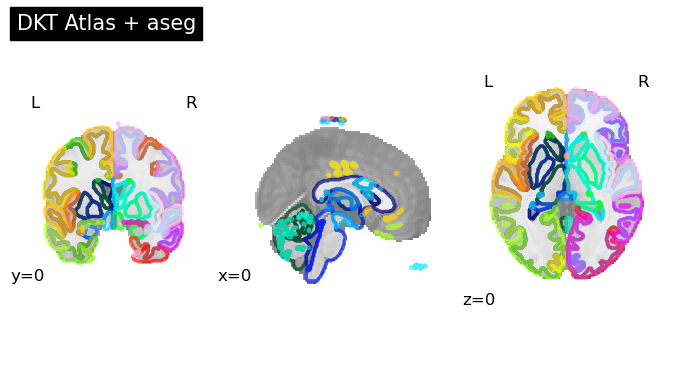

In [23]:

# plot the atlas image
plotting.plot_roi(atlas_img, view_type="contours",title='DKT Atlas + aseg', cut_coords=(0, 0, 0), display_mode='ortho', draw_cross=False)